### Try to build our own NDE, not conditioned on anything. Only work on magnitudes.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, Photulator, StandardScaler

In [4]:
## Load the NN emulator for mags: `Photulator`
with open('./phot_best_loss_model.pkl', 'rb') as f:
    photulator = pickle.load(f)

In [5]:
# flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])
# zero_flag = (np.mean(np.load('./train_sed/log_spec_all.npy'), axis=1) < -30)
# # log_spec_all = np.load('./train_sed/log_spec_all.npy')[~zero_flag]
# phot_all = np.load('./train_sed/phot_all.npy')[~zero_flag]
# params = np.load('./train_sed/param_all.npy')[:, ~flag][~zero_flag]

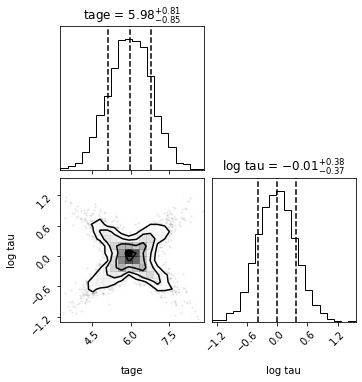

In [8]:
# y_test = np.random.multivariate_normal(mean=[6, 0], cov=[[0.5, 0.3], [0.3, 0.1]], size=3000)
y_test1 = np.random.multivariate_normal(mean=[6, 0], cov=[[0.7, 0.3], [0.3, 0.1]], size=1500)
y_test2 = np.random.multivariate_normal(mean=[6, 0], cov=[[-0.7, 0.3], [0.3, -0.1]], size=1500)
y_test = np.vstack([y_test1, y_test2])
y_test = Tensor(y_test)
x_test = photulator.predict_mag(y_test).cpu().detach().numpy()
x_test = Tensor(x_test).to('cuda')

figure = corner.corner(y_test.cpu().detach().numpy(), quantiles=[0.16, 0.5, 0.84], 
                       labels=['tage', 'log tau'],
                       show_titles=True, title_kwargs={"fontsize": 12})


In [11]:
# from popsed.nde import diff_KL_w2009_eq29
from popsed.speculator import StandardScaler
from popsed.nde import NeuralDensityEstimator
from geomloss import SamplesLoss

In [12]:
# NDE = NeuralDensityEstimator(method='nsf')
# NDE.build(x_test, optimizer='adam')
# NDE.train(n_epochs=4000, display=True)
# with open('./best_loss_model_nde_nsf.pkl', 'rb') as f:
#     NDE = pickle.load(f)
# samples = NDE.sample(2000)

### We try to achieve our goal with loss = Sinkhorn(X, Y), where X is the observed SED, and Y is the model output.

In [13]:
NDE_theta = NeuralDensityEstimator(method='nsf', num_transforms=7)
NDE_theta.build(y_test, optimizer='adam', lr=1e-3)
NDE_theta.min_loss = 0.02
NDE_theta.best_loss_epoch = 0

scaler = StandardScaler(device='cuda')
scaler.fit(x_test)

In [14]:
patience = 5
N_samples = 3000

In [15]:
X = scaler.transform(x_test)

# Define a Sinkhorn (~Wasserstein) loss between sampled measures
L = SamplesLoss(loss="sinkhorn", p=1, blur=.05, scaling=0.5)
for epoch in trange(50, desc='Training NDE_theta', unit='epochs'):
    NDE_theta.optimizer.zero_grad()
    Y = scaler.transform(photulator.predict_mag(NDE_theta.sample(N_samples)))
    loss = L(X, Y)
    loss.backward()
    NDE_theta.optimizer.step()
    NDE_theta.train_loss_history.append(loss.item())
    
NDE_theta.optimizer.param_groups[0]['lr'] = 5e-4
L = SamplesLoss(loss="sinkhorn", p=1, blur=.05, scaling=0.8)
for epoch in trange(200, desc='Training NDE_theta', unit='epochs'):
    NDE_theta.optimizer.zero_grad()
    Y = scaler.transform(photulator.predict_mag(NDE_theta.sample(N_samples)))
    loss = L(X, Y)
    if loss.item() < NDE_theta.min_loss:
        NDE_theta.min_loss = loss.item()
        if epoch - NDE_theta.best_loss_epoch > patience:
            # Don't save model too frequently
            NDE_theta.best_loss_epoch = epoch
            NDE_theta.save_model(
                f'best_loss_model_nsf_sinkhorn.pkl')
    loss.backward()
    NDE_theta.optimizer.step()
    NDE_theta.train_loss_history.append(loss.item())

Training NDE_theta: 100%|██████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.76epochs/s]


(0.006872430415264191, 0.1)

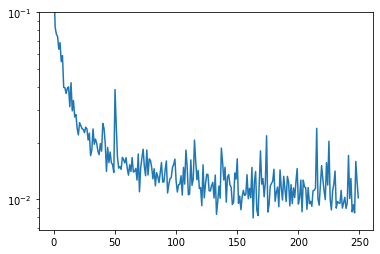

In [16]:
plt.plot(NDE_theta.train_loss_history)
plt.yscale('log')
plt.ylim(-0.01, 0.1)

In [17]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch])

Best epoch: 113
Best loss: 0.011882500723004341


In [27]:
with open('./best_loss_model_nsf_sinkhorn.pkl', 'rb') as f:
    NDE_theta = pickle.load(f)

In [28]:
samples = NDE_theta.sample(3000)
samples_logp = NDE_theta.net.log_prob(samples).detach()
photulator.predict_mag(samples)

# import torch.nn.functional as F
# out = F.kl_div(samples_logp, samples_logp)

tensor([[45.4467, 43.7833, 42.9792, 42.6161, 42.3091],
        [45.4897, 43.8333, 43.0283, 42.6659, 42.3560],
        [44.5108, 43.1469, 42.5199, 42.2150, 41.9490],
        ...,
        [44.4076, 43.1206, 42.5276, 42.2341, 41.9725],
        [45.8625, 44.1453, 43.2987, 42.9157, 42.5861],
        [43.3159, 42.2397, 41.8152, 41.5893, 41.3796]], device='cuda:0',
       grad_fn=<AddBackward0>)

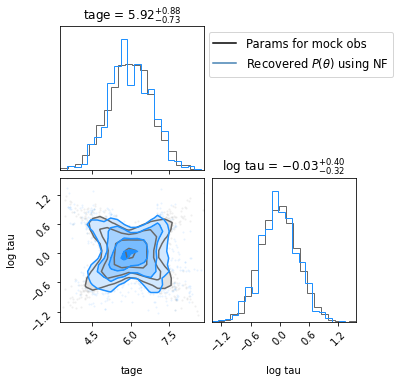

In [57]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using NF')

labels = ['tage', 'log tau']

figure = corner.corner(y_test.cpu().detach().numpy(), 
                       color='dimgray', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.7, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(NDE_theta.sample(3000).cpu().detach().numpy(), 
                  fig=figure, labels=labels, #range=[[3, 9], [-2, 2]],
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.7, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

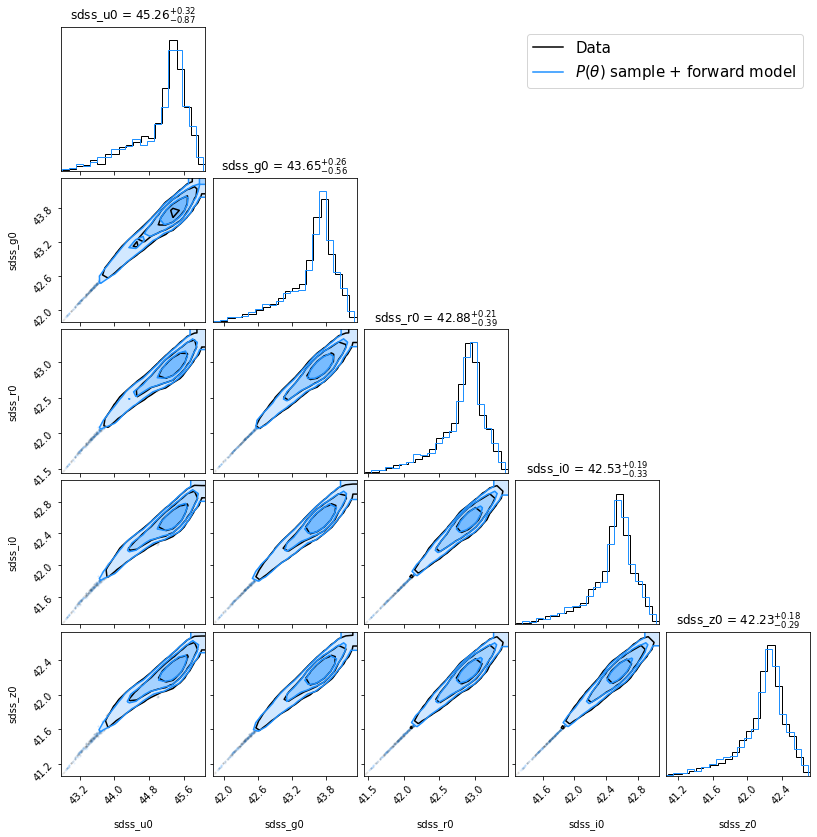

In [33]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = [f'sdss_{f}0' for f in 'ugriz']

figure = corner.corner(x_test.cpu().detach().numpy(), 
                       color='k', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.7, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12})

# nf_plot = corner.corner(samples.cpu().detach().numpy(), 
#                   fig=figure, labels=labels,
#                   color='tomato', #quantiles=[0.16, 0.5, 0.84], 
#                   smooth=0.5, fill_contours=True,
#                   show_titles=False, title_kwargs={"fontsize": 12})

nf_plot = corner.corner(photulator.predict_mag(samples).cpu().detach().numpy(), 
                  fig=figure, labels=labels,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.7, fill_contours=True,
                  show_titles=False, title_kwargs={"fontsize": 12})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

https://zhuanlan.zhihu.com/p/33752313
   
https://dfdazac.github.io/sinkhorn.html

https://zhuanlan.zhihu.com/p/25071913